# Projet Optimisation Linéaire - Planification de la production d'électricité
##### Alexandre Castanié / Achraf Amrani
---

In [1]:
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from Proj_Lin import prev,prev2,prev3

### 1. Modèle de base des centrales thermiques

Dans un premier temps, on ne considère que les centrales thermiques d'un parc de production. Ces centrales sont regroupées en 3 catégories. La **table 1** contient leur nombre *nb*, leur puissance minimale *Pmin*, leur puissance maximale *Pmax* et leur coût horaire pour chaque mégawatt produit *Cmwh*.

In [4]:
periodes,demande,duree = gp.multidict({'p1':[15000,6], 'p2':[30000,3], 'p3':[25000,6], 'p4':[40000,3],'p5':[27000,6]})

categories,Pmax,Pmin,cout,nb,cbase,cmwh,cstart=gp.multidict({'A':[2000,850,1.5,12,1000,2,2000],'B':[1750,1250,1.38,10,2600,1.3,1000],'C':[4000,1500,2.75,5,3000,3,500]})

nbmax={(k,p):nb[k] for k in categories for p in periodes}

<center>

| catégorie | nb | Pmin (MW) | Pmax (MW) | Cmwh (euros/MWh) |
|-----------|----|-----------|-----------|------------------|
| A         | 12 | 850       | 2000      | 1.50             |
| B         | 10 | 1250      | 1750      | 1.38             |
| C         | 5  | 1500      | 4000      | 2.75             |

**Table 1. Caractérisation des centrales par catégorie**

</center>

Le problème d'optimisation est composé des variables suivantes:

- **n<sub>k,p</sub>** le nombre de centrales allumées à chaque période p pour chaque catégorie k
- **y<sub>k,p</sub>** la puissance produite par l'ensemble des centrales à chaque période p pour chaque catégorie k  

Avec les paramètres suivants :
- **Cmwh** le coût horaire par mégawatt généré en euros/MWh
- **delta** la durée d'une période en heure
- **D** la puissance demandée/soutirée en MW
- **Pmin** la puissance minimale en MW
- **Pmax** la puissance maximale en MW

In [4]:
model=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n=model.addVars(categories,periodes,lb=0,ub=nbmax,vtype=gp.GRB.INTEGER)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y=model.addVars(categories,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)

Set parameter TokenServer to value "dev.cma.mines-paristech.fr"


Le modèle d'optimisation s'écrit ainsi :

$$ \min_{y \in \mathbb{R}^{k\times p}} \sum_{k \in [A,B,C]} \sum_{p=1}^5 \delta_p .Cmwh_k.  y_{k,p}$$  
**s.t.** $$\sum_{k \in [A,B,C]} y_{k,p} \ge D_p$$  
$$Pmin_k.n_{k,p} \le y_{k,p} \le Pmax_k.n_{k,p}$$
$$ y_{k,p}\ge 0, n_{k,p}\ge 0$$  
$$\forall k \in [A,B,C], \forall p \in [\![1,5]\!]$$

In [5]:
#fonction objective
model.setObjective(gp.quicksum(y[k,p] * duree[p] * cout[k] for k in categories for p in periodes), gp.GRB.MINIMIZE)

In [6]:
#contraintes
contrainte1=model.addConstrs((y.sum('*',p)>=demande[p] for p in periodes)) 
contrainte12=model.addConstrs((Pmin[k]*n[k,p]<=y[k,p] for k in categories for p in periodes))
contrainte13=model.addConstrs((y[k,p]<=Pmax[k]*n[k,p] for k in categories for p in periodes)) 
#résolution
model.update()
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35 rows, 30 columns and 75 nonzeros
Model fingerprint: 0x275a7362
Variable types: 15 continuous, 15 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [4e+00, 2e+01]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+04, 4e+04]
Found heuristic solution: objective 1379250.0000
Presolve removed 28 rows and 24 columns
Presolve time: 0.01s
Presolved: 7 rows, 6 columns, 15 nonzeros
Found heuristic solution: objective 940650.00000
Variable types: 0 continuous, 6 integer (0 binary)

Root relaxation: objective 8.694000e+05, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 869400.000    0    1 940650.000 869400.000  7.57%     -    0s
H 

Affichage du nombre de centrales allumées à chaque période pour chaque catégorie

In [32]:
ndict={k:[int(v.x) for v in n.select(k,'*')] for k in categories}
df=pd.DataFrame(ndict)
df.head()

,A,B,C
0,0,10,0
1,12,10,0
2,4,10,0
3,12,10,0
4,5,10,0


Affichage de la puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie

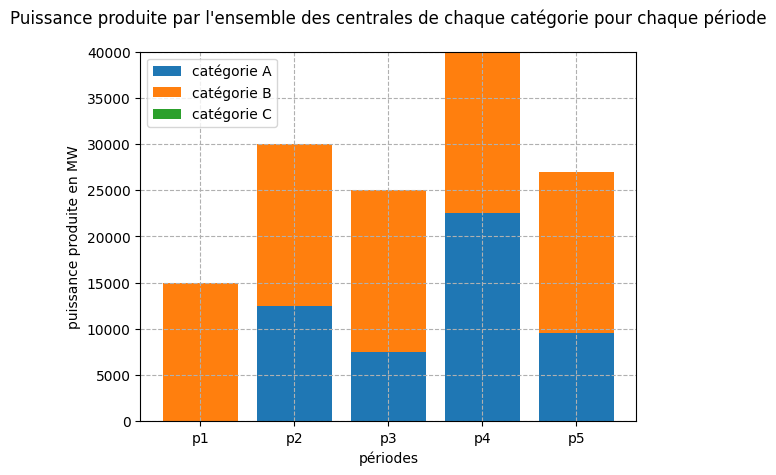

In [39]:
pdict={k:[v.x for v in y.select(k,'*')] for k in categories}
df12=pd.DataFrame(pdict)
plt.bar(periodes,df12['A'],label='catégorie A')
plt.bar(periodes,df12['B'],bottom=df12['A'],label='catégorie B')
plt.bar(periodes,df12['C'],bottom=df12['A']+df12['B'],label='catégorie C')
plt.legend()
plt.xlabel('périodes')
plt.ylabel('puissance produite en MW')
plt.title("Puissance produite par l'ensemble des centrales de chaque catégorie pour chaque période",pad=20)
plt.grid(linestyle='dashed')
plt.show()

### 2. Coûts d'opération

Nous allons maintenant améliorer le modèle en précisant l'intégration des coûts
<center>

| catégorie | Cstart (euros) | Cbase (euros/h) | Cmwh (euros/MWh) |
|-----------|----------------|-----------------|------------------|
| A         | 2000           | 1000            | 2.0              |
| B         | 1000           | 2600            | 1.3              |
| C         | 500            | 3000            | 3                |

**Table 2. Coûts des centrales par catégorie**

</center>
Avec:

- **Cstart** le coût de la centrale associé à son démarrage
- **Cbase** le coût de la centrale associé à son fonctionnement durant une heure à puissance minimale
- **Cmwh** le coût de la centrale associé à la génération d'1MWh supplémentaire au delà de la puissance minimale

#### 2.1 Rajout des couts à Pmin Cbase et de fonctionnement pour génerer 1MWh supplémentaire Cmwh

Le modèle d'optimisation devient :

$$ \min_{y \in \mathbb{R}^{k \times p}} \sum_{k \in [A,B,C]} \sum_{p=1}^5 [\delta_p.Cmwh.(y_{k,p}-Pmin_k.n_{k,p})+Cbase_k.\delta _p.n_{k,p}]$$  
**s.t.** $$\sum_{k \in [A,B,C]} y_{k,p} \ge D_p$$  
$$Pmin_k.n_{k,p} \le y_{k,p} \le Pmax_k.n_{k,p}$$
$$ y_{k,p}\ge 0, n_{k,p}\ge 0$$  
$$\forall k \in [A,B,C], \forall p \in [\![1,5]\!]$$

In [5]:
model21=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n21=model21.addVars(categories,periodes,lb=0,ub=nbmax,vtype=gp.GRB.INTEGER)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y21=model21.addVars(categories,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)

In [36]:
model21.setObjective(gp.quicksum(duree[p] * cmwh[k]*(y21[k,p]-Pmin[k]*n21[k,p]) + cbase[k]*duree[p]*n21[k,p]  for k in categories for p in periodes), gp.GRB.MINIMIZE)

In [41]:
contrainte21=model21.addConstrs((y21.sum('*',p)>=demande[p] for p in periodes)) 
contrainte22=model21.addConstrs((Pmin[k]*n21[k,p]<=y21[k,p] for k in categories for p in periodes))
contrainte23=model21.addConstrs((y21[k,p]<=Pmax[k]*n21[k,p] for k in categories for p in periodes)) 

model21.update()
model21.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35 rows, 30 columns and 75 nonzeros
Model fingerprint: 0x9f9335e5
Variable types: 15 continuous, 15 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [4e+00, 9e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+04, 4e+04]

MIP start from previous solve produced solution with objective 1.0803e+06 (0.01s)
Loaded MIP start from previous solve with objective 1.0803e+06

Presolve removed 28 rows and 24 columns
Presolve time: 0.01s
Presolved: 7 rows, 6 columns, 15 nonzeros
Found heuristic solution: objective 992400.00000
Variable types: 0 continuous, 6 integer (0 binary)

Root relaxation: objective 9.780000e+05, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

#### 2.2 Rajout du cout de démarrage Cstart

L'intégration de Cstart au modèle implique de connaître à quel moment et pour quelle catégorie une centrale est démarrée. C'est le rôle que va jouer la variable **x<sub>k,p</sub>** ajoutée au modèle et qui peut s'exprimer comme la différence entre le nombre de centrales allumées à la période p et le nombre de centrales allumées à la période p-1. Il faudra alors également ajouter une contrainte pour le cas p=0 (1ère période).  
Le modèle d'optimisation devient :

$$ \min_{y \in \mathbb{R}^{k \times p}} \sum_{k \in [A,B,C]} \sum_{p=1}^5 [\delta_p.Cmwh.(y_{k,p}-Pmin_k.n_{k,p})+Cbase_k.\delta _p.n_{k,p}+Cstart.x_{k,p}]$$  
**s.t.** $$\sum_{k \in [A,B,C]} y_{k,p} \ge D_p$$  
$$Pmin_k.n_{k,p} \le y_{k,p} \le Pmax_k.n_{k,p}$$
$$x_{k,p} \ge n_{k,p} - n_{k,p-1}$$  
$$x_{k,0}=n_{k,0}$$
$$ y_{k,p}\ge 0, n_{k,p}\ge 0$$ 
$$\forall k \in [A,B,C], \forall p \in [\![1,5]\!]$$ 

In [34]:
model22=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n22=model22.addVars(categories,periodes,lb=0,ub=nbmax,vtype=gp.GRB.INTEGER)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y22=model22.addVars(categories,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales allumées
x22=model22.addVars(categories,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)

In [35]:
model22.setObjective(gp.quicksum(duree[p] * cmwh[k]*(y22[k,p]-Pmin[k]*n22[k,p]) 
+ cbase[k]*duree[p]*n22[k,p] + cstart[k]*x22[k,p]  for k in categories for p in periodes), gp.GRB.MINIMIZE)

In [36]:
contrainte221=model22.addConstrs((y22.sum('*',p)>=demande[p] for p in periodes)) 
contrainte222=model22.addConstrs((Pmin[k]*n22[k,p]<=y22[k,p] for k in categories for p in periodes))
contrainte223=model22.addConstrs((y22[k,p]<=Pmax[k]*n22[k,p] for k in categories for p in periodes)) 
contrainte224=model22.addConstrs((x22[k,p]>=n22[k,p]-n22[k,periodes[prev(p,"")]] for k in categories for p in periodes)) 
contrainte225=model22.addConstrs((x22[k,'p1']==n22[k,'p1'] for k in categories))


model22.update()
model22.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 53 rows, 45 columns and 120 nonzeros
Model fingerprint: 0xe94eb5e8
Variable types: 30 continuous, 15 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [4e+00, 9e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+04, 4e+04]
Found heuristic solution: objective 1389900.0000
Presolve removed 6 rows and 3 columns
Presolve time: 0.00s
Presolved: 47 rows, 42 columns, 111 nonzeros
Variable types: 0 continuous, 42 integer (0 binary)
Found heuristic solution: objective 1380884.7000

Root relaxation: objective 1.011257e+06, 18 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1011257.14    0    7 1380884.70 1011257.14  26.8%     -    0

Tableau du nombre de centrales démarées

In [37]:
pdict21={k:[int(v.x) for v in x22.select(k,'*')] for k in categories}
df21=pd.DataFrame(pdict21)
df21.head()

,A,B,C
0,12,2,0
1,0,6,0
2,0,0,0
3,0,2,0
4,0,0,0


Affichage de la puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie

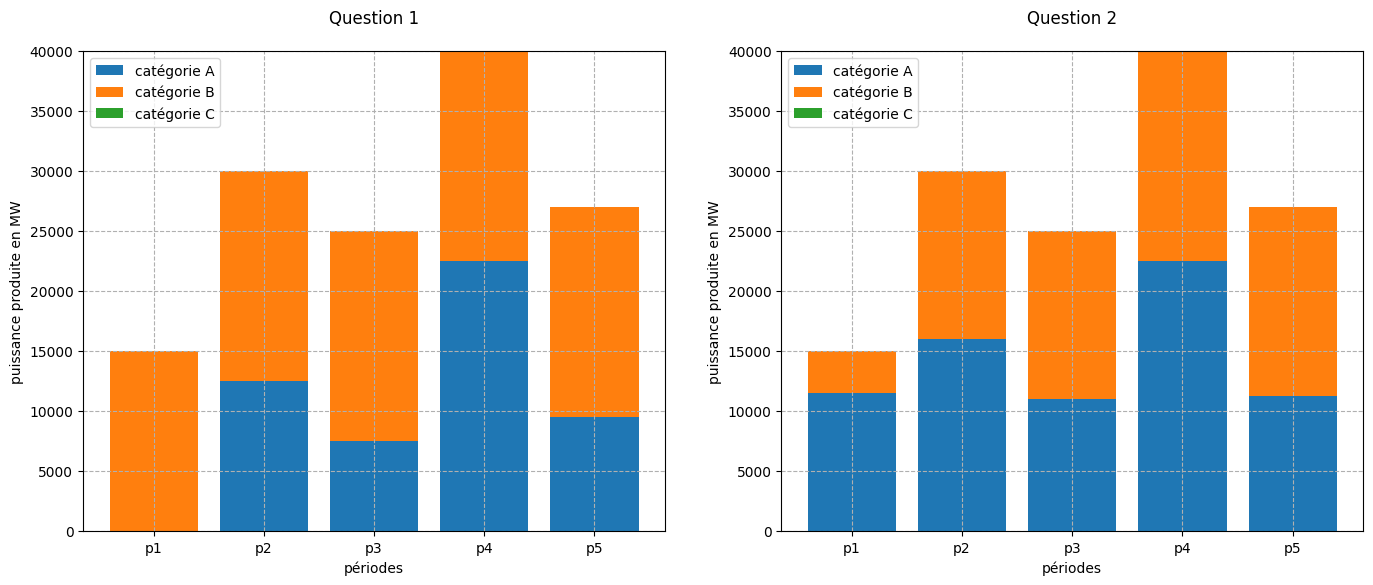

In [48]:
pdict22={k:[v.x for v in y22.select(k,'*')] for k in categories}
df22=pd.DataFrame(pdict22)

plt.gcf().subplots_adjust(left=0, bottom=0, right=2, top=1)
plt.subplot(1,2,1)
plt.bar(periodes,df12['A'],label='catégorie A')
plt.bar(periodes,df12['B'],bottom=df12['A'],label='catégorie B')
plt.bar(periodes,df12['C'],bottom=df12['A']+df12['B'],label='catégorie C')
plt.legend()
plt.xlabel('périodes')
plt.ylabel('puissance produite en MW')
plt.title("Question 1",pad=20)
plt.grid(linestyle='dashed')
plt.subplot(1,2,2)
plt.bar(periodes,df22['A'],label='catégorie A')
plt.bar(periodes,df22['B'],bottom=df22['A'],label='catégorie B')
plt.bar(periodes,df22['C'],bottom=df22['A']+df22['B'],label='catégorie C')
plt.legend()
plt.xlabel('périodes')
plt.ylabel('puissance produite en MW')
plt.title("Question 2",pad=20)
plt.grid(linestyle='dashed')

plt.show()

On observe que les centrales de catégorie C possèdent toujours un coût trop élevé pour être appelées et qu'un rééquilibrage s'est produit entre la production des centrales de catégorie A et celles de catégorie B.

### 3. Réserve de puissance

Cette question s'intéresse à l'intégration d'une réserve de puissance sous forme de capacité supplémentaire disponible afin de supporter une hausse de 15% de la demande prévue. Après ajout de ces contraintes (une pour chaque période), le modèle s'écrit:

$$ \min_{y \in \mathbb{R}^{k \times p}} \sum_{k \in [A,B,C]} \sum_{p=1}^5 [\delta_p.Cmwh.(y_{k,p}-Pmin_k.n_{k,p})+Cbase_k.\delta _p.n_{k,p}+Cstart.x_{k,p}]$$  
**s.t.** $$\sum_{k \in [A,B,C]} y_{k,p} \ge D_p$$  
$$Pmin_k.n_{k,p} \le y_{k,p} \le Pmax_k.n_{k,p}$$
$$x_{k,p} \ge n_{k,p} - n_{k,p-1}$$  
$$x_{k,0}=n_{k,0}$$ 
$$ reserve_p \ge 0.15 \times D_p$$  
$$ y_{k,p}\ge 0, n_{k,p}\ge 0$$
$$\forall k \in [A,B,C], \forall p \in [\![1,5]\!]$$ 

Avec :  
$ reserve_p = \sum_{k \in [A,B,C]} (n_{k,p}.Pmax_k - y_{k,p})$


In [3]:
model3=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n3=model3.addVars(categories,periodes,lb=0,ub=nbmax,vtype=gp.GRB.INTEGER)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y3=model3.addVars(categories,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales allumées
x3=model3.addVars(categories,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)

Set parameter TokenServer to value "dev.cma.mines-paristech.fr"


In [4]:
model3.setObjective(gp.quicksum(duree[p] * cmwh[k]*(y3[k,p]-Pmin[k]*n3[k,p]) 
+ cbase[k]*duree[p]*n3[k,p] + cstart[k]*x3[k,p]  for k in categories for p in periodes), gp.GRB.MINIMIZE)

In [5]:
reserve={p:gp.quicksum(n3[k,p]*Pmax[k]-y3[k,p] for k in categories) for p in periodes}

In [6]:
contrainte31=model3.addConstrs((y3.sum('*',p)>=demande[p] for p in periodes)) 
contrainte32=model3.addConstrs((Pmin[k]*n3[k,p]<=y3[k,p] for k in categories for p in periodes))
contrainte33=model3.addConstrs((y3[k,p]<=Pmax[k]*n3[k,p] for k in categories for p in periodes)) 
contrainte34=model3.addConstrs((x3[k,p]>=n3[k,p]-n3[k,periodes[prev(p,"")]] for k in categories 
for p in periodes)) 
contrainte35=model3.addConstrs((x3[k,'p1']==n3[k,'p1'] for k in categories))
contrainte36=model3.addConstrs((reserve[p]>=0.15*demande[p] for p in periodes))

model3.update()
model3.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 58 rows, 45 columns and 150 nonzeros
Model fingerprint: 0x8ceebcfe
Variable types: 30 continuous, 15 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [4e+00, 9e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+03, 4e+04]
Found heuristic solution: objective 1371275.0000
Presolve removed 6 rows and 3 columns
Presolve time: 0.00s
Presolved: 52 rows, 42 columns, 141 nonzeros
Variable types: 15 continuous, 27 integer (0 binary)

Root relaxation: objective 1.012257e+06, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1012257.14    0    7 1371275.00 1012257.14  26.2%     -    0s
H    0     0                    1022435.0000 1

Tableau du nombre de centrales allumées pour chaque catégorie à chaque période

In [9]:
pdict31={k:[int(v.x) for v in n3.select(k,'*')] for k in categories}
df31=pd.DataFrame(pdict31)
df31.head()

,A,B,C
0,12,2,0
1,12,8,0
2,12,8,0
3,12,9,2
4,12,9,0


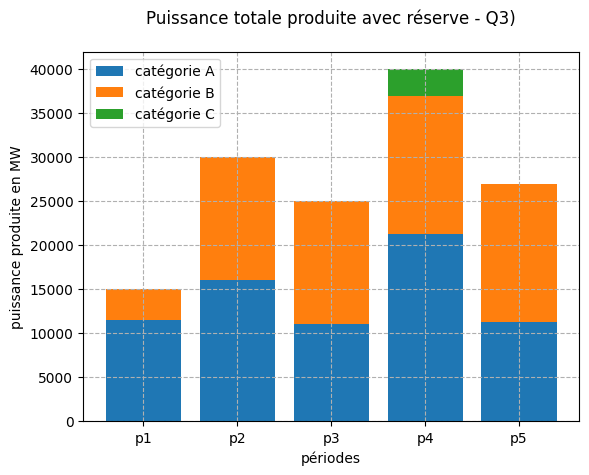

In [10]:
pdict3={k:[v.x for v in y3.select(k,'*')] for k in categories}
df3=pd.DataFrame(pdict3)

plt.bar(periodes,df3['A'],label='catégorie A')
plt.bar(periodes,df3['B'],bottom=df3['A'],label='catégorie B')
plt.bar(periodes,df3['C'],bottom=df3['A']+df3['B'],label='catégorie C')
plt.legend()
plt.xlabel('périodes')
plt.ylabel('puissance produite en MW')
plt.title("Puissance totale produite avec réserve - Q3)",pad=20)
plt.grid(linestyle='dashed')

plt.show()

On observe que 2 des 5 centrales de la catégorie C sont allumées à la période 4. Il est en effet nécessaire de les appeler à cette période car il faut à la fois satisfaire la contrainte de demande plus élevée qu'aux autres périodes et en plus satisfaire la contrainte de réserve. Cela augmente bien évidemment le coût global.

### 4. Planification cyclique

La question suivante consiste à planifier sur une période plus longue qu'une journée mais sous l'hypothèse d'un profil de demande journalier identique sur toute la durée de planification. Ainsi, la première période de la journée type va succéder à la dernière période de cette même journée.  
Le problème d'optimisation va s'écrire comme :

$$ \min_{y \in \mathbb{R}^{k \times p}} \sum_{k \in [A,B,C]} \sum_{p=1}^5 [\delta_p.Cmwh.(y_{k,p}-Pmin_k.n_{k,p})+Cbase_k.\delta _p.n_{k,p}+Cstart.x_{k,p}]$$  
**s.t.** $$\sum_{k \in [A,B,C]} y_{k,p} \ge D_p$$  
$$Pmin_k.n_{k,p} \le y_{k,p} \le Pmax_k.n_{k,p}$$
$$x_{k,p} \ge n_{k,p} - n_{k,p-1_{cyclique}}$$  
$$ reserve_p \ge 0.15 \times D_p$$  
$$ y_{k,p}\ge 0, n_{k,p}\ge 0$$  
$$\forall k \in [A,B,C], \forall p \in [\![1,5]\!]$$ 

In [11]:
model4=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n4=model4.addVars(categories,periodes,lb=0,ub=nbmax,vtype=gp.GRB.INTEGER)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y4=model4.addVars(categories,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales démarrées
x4=model4.addVars(categories,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)

In [12]:
model4.setObjective(gp.quicksum(duree[p] * cmwh[k]*(y4[k,p]-Pmin[k]*n4[k,p]) 
+ cbase[k]*duree[p]*n4[k,p] + cstart[k]*x4[k,p]  for k in categories for p in periodes), gp.GRB.MINIMIZE)

In [13]:
reserve4={p:sum(n4[k,p]*Pmax[k]-y4[k,p] for k in categories) for p in periodes}

In [14]:
contrainte41=model4.addConstrs((y4.sum('*',p)>=demande[p] for p in periodes)) 
contrainte42=model4.addConstrs((Pmin[k]*n4[k,p]<=y4[k,p] for k in categories for p in periodes))
contrainte43=model4.addConstrs((y4[k,p]<=Pmax[k]*n4[k,p] for k in categories for p in periodes)) 
contrainte44=model4.addConstrs((x4[k,p]>=n4[k,p]-n4[k,periodes[prev(p,'cyclique')]] for k in categories 
for p in periodes))
contrainte45=model4.addConstrs((reserve4[p]>=0.15*demande[p] for p in periodes))

model4.update()
model4.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55 rows, 45 columns and 150 nonzeros
Model fingerprint: 0xeb00c8f1
Variable types: 30 continuous, 15 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [4e+00, 9e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+03, 4e+04]
Found heuristic solution: objective 1360875.0000
Presolve time: 0.00s
Presolved: 55 rows, 45 columns, 150 nonzeros
Variable types: 15 continuous, 30 integer (0 binary)
Found heuristic solution: objective 1355025.0000

Root relaxation: objective 9.855143e+05, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 985514.286    0    7 1355025.00 985514.286  27.3%     -    0s
H    0     0                    995

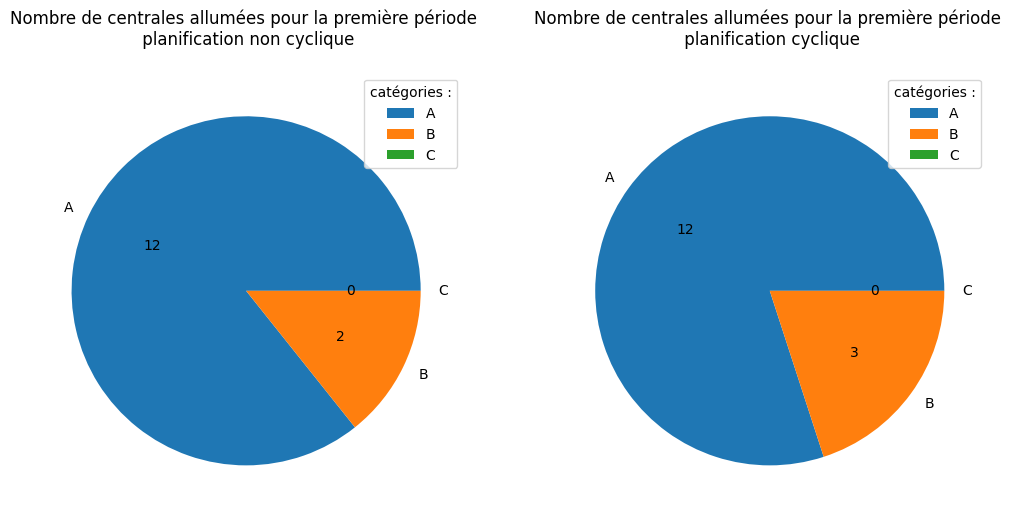

In [45]:
pdict4={k:[int(v.x) for v in n4.select(k,'*')] for k in categories}
df4=pd.DataFrame(pdict4)

plt.gcf().subplots_adjust(left=0, bottom=0, right=1.5, top=1)
plt.subplot(1,2,1)
plt.pie(df31.iloc[0,:],autopct=lambda p: '{:.0f}'.format(p * sum(df31.iloc[0,:]) / 100),labels=categories)
plt.legend(title='catégories :')
plt.title("Nombre de centrales allumées pour la première période \n planification non cyclique",pad=20)
plt.subplot(1,2,2)
plt.pie(df4.iloc[0,:],autopct=lambda p: '{:.0f}'.format(p * sum(df4.iloc[0,:]) / 100),labels=categories)
plt.legend(title='catégories :')
plt.title("Nombre de centrales allumées pour la première période \n planification cyclique",pad=20)

plt.show()

L'intégration d'une planification cyclique va s'observer uniquement à la première période. En effet, la première période succède à la dernière et c'est pourquoi une centrale de catégorie B supplémentaire est appelée.

### 5. Centrales hydroélectriques

#### 5.1 Centrales

Nous allons maintenant compléter le parc de production en ajoutant deux centrales hydroélectriques dont les caractéristiques sont les suivantes :

<center>

| catégorie | nb | Puissance (MW) | Cstart (euros)   | Cbase (euros/h) |
|-----------|----|----------------|------------------|-----------------|
| H1        | 1  | 900            | 1500             |90               |
| H2        | 1  | 1400           | 1200             |150              |

**Table 3. Caractérisation des centrales hydroélectriques**

</center>

Ajouter au modèle les deux centrales hydroélectriques revient à ajouter deux catégories supplémentaires, une pour chaque centrale. La formulation mathématique du problème reste inchangée.

In [3]:
categories5,Pmax5,Pmin5,nb5,cbase5,cmwh5,cstart5,Vab=gp.multidict({'A':[2000,850,12,1000,2,2000,0],
'B':[1750,1250,10,2600,1.3,1000,0],'C':[4000,1500,5,3000,3,500,0], 'H1':[900,900,1,90,0,1500,0.31], 'H2':[1400,1400,1,150,0,1200,0.47]})

nbmax5={(k,p):nb5[k] for k in categories5 for p in periodes}

NameError: name 'periodes' is not defined

In [48]:
model5=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n5=model5.addVars(categories5,periodes,lb=0,ub=nbmax5,vtype=gp.GRB.INTEGER)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y5=model5.addVars(categories5,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales allumées
x5=model5.addVars(categories5,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)

In [49]:
model5.setObjective(gp.quicksum(duree[p] * cmwh5[k]*(y5[k,p]-Pmin5[k]*n5[k,p]) 
+ cbase5[k]*duree[p]*n5[k,p] + cstart5[k]*x5[k,p]  for k in categories5 for p in periodes), gp.GRB.MINIMIZE)

In [50]:
reserve5={p:sum(n5[k,p]*Pmax5[k]-y5[k,p] for k in categories5) for p in periodes}

In [51]:
contrainte511=model5.addConstrs((y5.sum('*',p)>=demande[p] for p in periodes)) 
contrainte512=model5.addConstrs((Pmin5[k]*n5[k,p]<=y5[k,p] for k in categories5 for p in periodes))
contrainte513=model5.addConstrs((y5[k,p]<=Pmax5[k]*n5[k,p] for k in categories5 for p in periodes)) 
contrainte514=model5.addConstrs((x5[k,p]>=n5[k,p]-n5[k,periodes[prev(p,'cyclique')]] for k in categories5 
for p in periodes))
contrainte515=model5.addConstrs((reserve5[p]>=0.15*demande[p] for p in periodes))

model5.update()
model5.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 85 rows, 75 columns and 250 nonzeros
Model fingerprint: 0xbcb39dfc
Variable types: 50 continuous, 25 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [4e+00, 9e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e+03, 4e+04]
Found heuristic solution: objective 1303285.0000
Presolve removed 20 rows and 10 columns
Presolve time: 0.00s
Presolved: 65 rows, 65 columns, 190 nonzeros
Variable types: 15 continuous, 50 integer (20 binary)
Found heuristic solution: objective 1302325.0000

Root relaxation: objective 8.884100e+05, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 888410.000    0    9 1302325.00 888410.000  31.8%     - 

In [52]:
ndict5={k:[int(v.x) for v in n5.select(k,'*')] for k in categories5}
df51=pd.DataFrame(ndict5)
df51.head()

,A,B,C,H1,H2
0,12,1,0,1,1
1,12,7,0,1,1
2,12,7,0,1,1
3,12,9,1,1,1
4,12,8,0,1,1


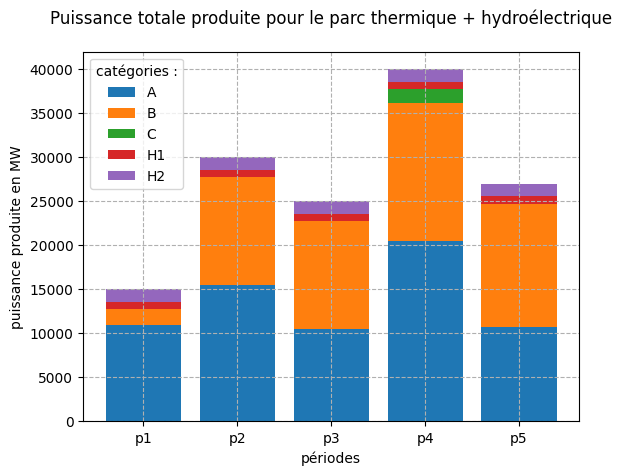

In [53]:
pdict5={k:[int(v.x) for v in y5.select(k,'*')] for k in categories5}
df5=pd.DataFrame(pdict5)

plt.bar(periodes,df5['A'],label='A')
plt.bar(periodes,df5['B'],bottom=df5['A'],label='B')
plt.bar(periodes,df5['C'],bottom=df5['A']+df5['B'],label='C')
plt.bar(periodes,df5['H1'],bottom=df5['A']+df5['B']+df5['C'],label='H1')
plt.bar(periodes,df5['H2'],bottom=df5['A']+df5['B']+df5['C']+df5['H1'],label='H2')
plt.legend(title="catégories :")
plt.xlabel('périodes')
plt.ylabel('puissance produite en MW')
plt.title("Puissance totale produite pour le parc thermique + hydroélectrique",pad=20)
plt.grid(linestyle='dashed')

plt.show()

#### 5.2 Pompage

La finitude du réservoir qui permet de faire tourner les turbines des centrales doit être prise en compte. Pour cela, deux pompes, une pour chaque centrale, sont utilisées pour maintenir le réservoir au même niveau que la veille. Ces pompes consomment 3000 MWh/mètre d'eau élevé et la vitesse d'abaissement du niveau de réservoir notée **Vab** est de 0.31 m/h pour H1 et 0.47 m/h pour H2.

Le problème de pompage va donc s'exprimer comme une seule contrainte et peut se formuler ainsi : L'énergie restante développée par le parc entier après satisfaction de la demande sur une journée doit être au moins égale à l'énergie de pompage nécessaire pour maintenir le réservoir au même niveau.

Le problème d'optimisation s'écrit alors :

$$ \min_{y \in \mathbb{R}^{k \times p}} \sum_{k \in [A,B,C,H1,H2]} \sum_{p=1}^5 [\delta_p.Cmwh.(y_{k,p}-Pmin_k.n_{k,p})+Cbase_k.\delta _p.n_{k,p}+Cstart.x_{k,p}]$$  
**s.t.** $$\sum_{k \in [A,B,C,H1,H2]} y_{k,p} \ge D_p$$  
$$Pmin_k.n_{k,p} \le y_{k,p} \le Pmax_k.n_{k,p}$$
$$x_{k,p} \ge n_{k,p} - n_{k,p-1_{cyclique}}$$  
$$ reserve_p \ge 0.15 \times D_p$$
$$ \sum_{k \in [A,B,C,H1,H2]} \sum_{p=1}^5 \delta_p(y_{k,p}-D_p) \ge 3000. \sum_{k \in [H1,H2]} \sum_{p=1}^5 (Vab_k.n_{k,p}.\delta_p) $$ 
$$ y_{k,p}\ge 0, n_{k,p}\ge 0$$  
$$\forall k \in [A,B,C,H1,H2], \forall p \in [\![1,5]\!]$$ 

In [54]:
model52=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n52=model52.addVars(categories5,periodes,lb=0,ub=nbmax5,vtype=gp.GRB.INTEGER)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y52=model52.addVars(categories5,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales démarrées à chaque période ppour chaque catégorie
x52=model52.addVars(categories5,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)

In [55]:
model52.setObjective(gp.quicksum(duree[p] * cmwh5[k]*(y52[k,p]-Pmin5[k]*n52[k,p]) 
+ cbase5[k]*duree[p]*n52[k,p] + cstart5[k]*x52[k,p]  for k in categories5 for p in periodes), gp.GRB.MINIMIZE)

reserve52={p:sum(n52[k,p]*Pmax5[k]-y52[k,p] for k in categories5) for p in periodes}

In [56]:
contrainte521=model52.addConstrs((y52.sum('*',p)>=demande[p] for p in periodes)) 
contrainte522=model52.addConstrs((Pmin5[k]*n52[k,p]<=y52[k,p] for k in categories5 for p in periodes))
contrainte523=model52.addConstrs((y52[k,p]<=Pmax5[k]*n52[k,p] for k in categories5 for p in periodes)) 
contrainte524=model52.addConstrs((x52[k,p]>=n52[k,p]-n52[k,periodes[prev(p,'cyclique')]] for k in categories5 for p in periodes))
contrainte525=model52.addConstrs((reserve52[p]>=0.15*demande[p] for p in periodes))
contrainte526=model52.addConstr(sum((y52.sum('*',p)-demande[p])*duree[p] for p in periodes)>=3000*sum(Vab[k]*n52[k,p]*duree[p] for k in ['H1','H2'] for p in periodes))

model52.update()
model52.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 86 rows, 75 columns and 285 nonzeros
Model fingerprint: 0x685c3f94
Variable types: 50 continuous, 25 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+03]
  Objective range  [4e+00, 9e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e+03, 6e+05]
Found heuristic solution: objective 1170970.0000
Presolve removed 20 rows and 10 columns
Presolve time: 0.00s
Presolved: 66 rows, 65 columns, 215 nonzeros
Variable types: 15 continuous, 50 integer (20 binary)
Found heuristic solution: objective 1132895.0000

Root relaxation: objective 9.851643e+05, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 985164.286    0    9 1132895.00 985164.286  13.0%     - 

In [58]:
ndict52={k:[int(v.x) for v in n52.select(k,'*')] for k in categories5}
df521=pd.DataFrame(ndict52)
df521.head()

,A,B,C,H1,H2
0,12,3,0,0,0
1,12,9,0,0,0
2,12,9,0,0,0
3,12,10,1,0,1
4,12,9,0,0,1


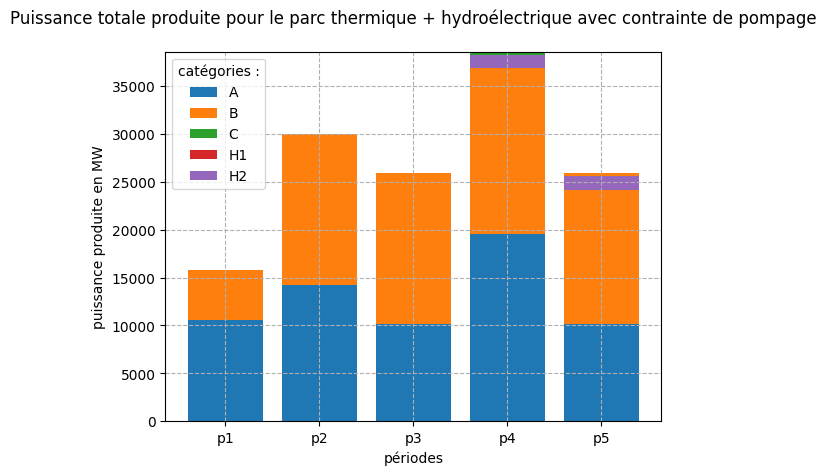

In [60]:
pdict52={k:[int(v.x) for v in y52.select(k,'*')] for k in categories5}
df52=pd.DataFrame(pdict52)

plt.bar(periodes,df52['A'],label='A')
plt.bar(periodes,df52['B'],bottom=df52['A'],label='B')
plt.bar(periodes,df52['C'],bottom=df52['A']+df52['B'],label='C')
plt.bar(periodes,df52['H1'],bottom=df52['A']+df52['B']+df52['C'],label='H1')
plt.bar(periodes,df52['H2'],bottom=df52['A']+df5['B']+df52['C']+df52['H1'],label='H2')
plt.legend(title="catégories :")
plt.xlabel('périodes')
plt.ylabel('puissance produite en MW')
plt.title("Puissance totale produite pour le parc thermique + hydroélectrique avec contrainte de pompage",pad=20)
plt.grid(linestyle='dashed')

plt.show()

#### 5.3 paliers de fonctionnement

Cette question consiste à améliorer le modèle des deux centrales en ajoutant 4 paliers de fonctionnement pour chaque centrale hydroélectrique:

<center>

|                    | H1 palier 1 | H1 palier 2 | H1 palier 3 | H1 palier 4 | H2 palier 1 | H2 palier 2 | H2 palier 3 | H2 palier 4 |  
|--------------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------| 
| puissance (MW)     | 900         | 950         | 1000        | 1100        | 1400        | 1500        | 1600        | 1700        |  
| abaissement (m/h)  | 0.31        | 0.33        | 0.35        | 0.38        | 0.47        | 0.50        | 0.53        | 0.56        |  
| coût (euros/h)     | 90          | 95          | 105         | 120         | 150         | 165         | 185         | 210         |  

</center>

En pratique, ces paliers sont considérés comme des centrales indépendantes avec comme contrainte que seul 1 des 4 paliers peut-être utilisé à chaque période pour les 2 centrales.  
Le problème d'optimisation s'écrit alors:

$$ \min_{y \in \mathbb{R}^{k \times p}} \sum_{k \in [A,...,H24]} \sum_{p=1}^5 [\delta_p.Cmwh.(y_{k,p}-Pmin_k.n_{k,p})+Cbase_k.\delta _p.n_{k,p}+Cstart.x_{k,p}]$$  
**s.t.** $$\sum_{k \in [A,...,H24]} y_{k,p} \ge D_p$$  
$$Pmin_k.n_{k,p} \le y_{k,p} \le Pmax_k.n_{k,p}$$
$$x_{k,p} \ge n_{k,p} - n_{k,p-1_{cyclique}}$$  
$$ reserve_p \ge 0.15 \times D_p$$
$$ \sum_{k \in [A,...,H24]} \sum_{p=1}^5 \delta_p(y_{k,p}-D_p) \ge 3000. \sum_{k \in [H11,...,H24]} \sum_{p=1}^5 (Vab_k.n_{k,p}.\delta_p) $$ 
$$ \sum_{k \in [H11,H12,H13,H14]} n_{k,p}=1 $$
$$ \sum_{k \in [H21,H22,H23,H24]} n_{k,p}=1 $$
$$ y_{k,p}\ge 0, n_{k,p}\ge 0, x_{k,p}\ge 0$$  
$$\forall k \in [A,...,H24], \forall p \in [\![1,5]\!]$$ 

In [5]:
categories53,Pmax53,Pmin53,nb53,cbase53,cmwh53,cstart53,Vab53=gp.multidict({'A':[2000,850,12,1000,2,2000,0],
'B':[1750,1250,10,2600,1.3,1000,0],'C':[4000,1500,5,3000,3,500,0], 'H11':[900,900,1,90,0,1500,0.31],
'H12':[950,950,1,95,0,1500,0.33], 'H13':[1000,1000,1,105,0,1500,0.35], 'H14':[1100,1100,1,120,0,1500,0.38],
'H21':[1400,1400,1,150,0,1200,0.47], 'H22':[1500,1500,1,165,0,1200,0.5], 'H23':[1600,1600,1,185,0,1200,0.53],
'H24':[1700,1700,1,210,0,1200,0.56]})

nbmax53={(k,p):nb53[k] for k in categories53 for p in periodes}

In [62]:
model53=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n53=model53.addVars(categories53,periodes,lb=0,ub=nbmax53,vtype=gp.GRB.INTEGER)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y53=model53.addVars(categories53,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales démarrées à chaque période ppour chaque catégorie
x53=model53.addVars(categories53,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)

In [63]:
model53.setObjective(gp.quicksum(duree[p] * cmwh53[k]*(y53[k,p]-Pmin53[k]*n53[k,p]) 
+ cbase53[k]*duree[p]*n53[k,p] + cstart53[k]*x53[k,p]  for k in categories53 for p in periodes), gp.GRB.MINIMIZE)

reserve53={p:sum(n53[k,p]*Pmax53[k]-y53[k,p] for k in categories53) for p in periodes}

In [64]:
contrainte531=model53.addConstrs((y53.sum('*',p)>=demande[p] for p in periodes)) 
contrainte532=model53.addConstrs((Pmin53[k]*n53[k,p]<=y53[k,p] for k in categories53 for p in periodes))
contrainte533=model53.addConstrs((y53[k,p]<=Pmax53[k]*n53[k,p] for k in categories53 for p in periodes)) 
contrainte534=model53.addConstrs((x53[k,p]>=n53[k,p]-n53[k,periodes[prev(p,'cyclique')]] for k in categories53 for p in periodes))
contrainte535=model53.addConstrs((reserve53[p]>=0.15*demande[p] for p in periodes))
contrainte536=model53.addConstr(sum((y53.sum('*',p)-demande[p])*duree[p] for p in periodes)>=3000*sum(Vab53[k]*n53[k,p]*duree[p] for k in categories53[3:11] for p in periodes))
contrainte537=model53.addConstrs((n53['H11',p]+n53['H12',p]+n53['H13',p]+n53['H14',p]==1 for p in periodes))
contrainte538=model53.addConstrs((n53['H21',p]+n53['H22',p]+n53['H23',p]+n53['H24',p]==1 for p in periodes))

model53.update()
model53.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 186 rows, 165 columns and 685 nonzeros
Model fingerprint: 0x7e263fac
Variable types: 110 continuous, 55 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+00, 9e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 1118546.0000
Presolve removed 80 rows and 40 columns
Presolve time: 0.00s
Presolved: 106 rows, 125 columns, 390 nonzeros
Variable types: 15 continuous, 110 integer (80 binary)
Found heuristic solution: objective 1090021.0000

Root relaxation: objective 9.868757e+05, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 986875.714    0    8 1090021.00 986875.714  9.46% 

In [65]:
ndict531={k:[int(v.x) for v in n53.select(k,'*')] for k in categories53}
df531=pd.DataFrame(ndict531)
df531.head()

,A,B,C,H11,H12,H13,H14,H21,H22,H23,H24
0,12,7,0,1,0,0,0,0,0,1,0
1,12,7,0,1,0,0,0,0,0,1,0
2,12,7,0,1,0,0,0,0,0,1,0
3,12,9,1,1,0,0,0,0,0,1,0
4,12,8,0,1,0,0,0,0,0,1,0


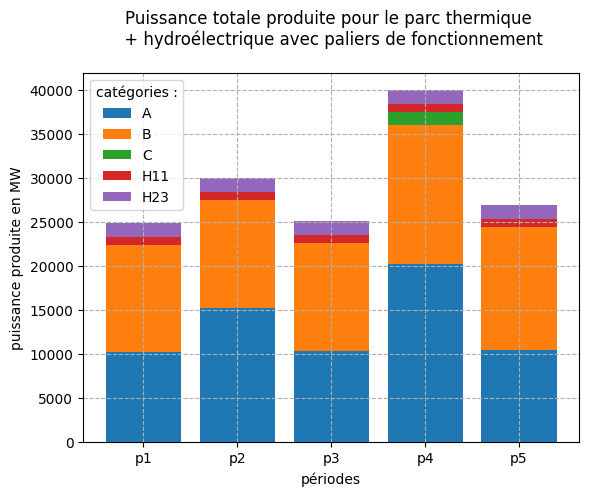

In [71]:
pdict53={k:[v.x for v in y53.select(k,'*')] for k in categories53}
df53=pd.DataFrame(pdict53)

plt.bar(periodes,df53['A'],label='A')
plt.bar(periodes,df53['B'],bottom=df53['A'],label='B')
plt.bar(periodes,df53['C'],bottom=df53['A']+df53['B'],label='C')
plt.bar(periodes,df53['H11'],bottom=df53['A']+df53['B']+df53['C'],label='H11')
plt.bar(periodes,df53['H23'],bottom=df53['A']+df53['B']+df53['C']+df53['H11'],label='H23')
plt.legend(title="catégories :")
plt.xlabel('périodes')
plt.ylabel('puissance produite en MW')
plt.title("Puissance totale produite pour le parc thermique \n + hydroélectrique avec paliers de fonctionnement",pad=20)
plt.grid(linestyle='dashed')

plt.show()

On observe que la 1ère centrale hydroélectrique fonctionne à son palier de fonctionnement n°1, et la 2ème à son palier de fonctionnement n°3, les autres n'étant pas optimaux.

#### 5.4 exclusion pompage et génération hydro

Nous allons dans cette question inclure au modèle précédent l'impossibilité de pomper simultanément au fonctionnement des centrales hydroélectriques. Pour cela, une variable binaire est ajoutée : **s** indique si au moins une centrale hydroélectrique est allumée. Pour cela, deux contraintes big M viennent compléter le modèle. Elles assurent par l'intermédiaire de **s** que si au moins une centrale hydroélectrique est allumée alors les pompes ne fonctionnent pas i.e. l'énergie de pompage est nulle.     
Le problème d'optimisation devient :
$$ \min_{y \in \mathbb{R}^{k \times p}} \sum_{k \in [A,...,H24]} \sum_{p=1}^5 [\delta_p.Cmwh.(y_{k,p}-Pmin_k.n_{k,p})+Cbase_k.\delta _p.n_{k,p}+Cstart.x_{k,p}]$$  
**s.t.** $$\sum_{k \in [A,...,H24]} y_{k,p} \ge D_p$$  
$$Pmin_k.n_{k,p} \le y_{k,p} \le Pmax_k.n_{k,p}$$
$$x_{k,p} \ge n_{k,p} - n_{k,p-1_{cyclique}}$$  
$$ reserve_p \ge 0.15 \times D_p$$
$$ \sum_{k \in [A,...,H24]} \sum_{p=1}^5 \delta_p(y_{k,p}-D_p) \ge 3000. \sum_{k \in [H11,...,H24]} \sum_{p=1}^5 (Vab_k.n_{k,p}.\delta_p) $$ 
$$ \sum_{k \in [H11,H12,H13,H14]} n_{k,p}=1 $$
$$ \sum_{k \in [H21,H22,H23,H24]} n_{k,p}=1 $$
$$ \sum_{k \in [H11,...,H24]} \sum_{p=1}^5 n_{k,p} \ge 1 - M1.(1-s) $$
$$ \sum_{k \in [H11,...,H24]} \sum_{p=1}^5 (Vab_k.n_{k,p}.\delta_p) \le M2.(1-s) $$
$$ y_{k,p}\ge 0, n_{k,p}\ge 0, x_{k,p}\ge 0, s \in [\![0,1]\!]$$  
$$\forall k \in [A,...,H24], \forall p \in [\![1,5]\!]$$  

Il est sans doute possible d'exprimer cette contrainte sans passer par une variable binaire et ainsi simplifier le système mais nous avons préferé passer à la suite et avancer plutôt que d'explorer cette voie.

In [6]:
model54=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n54=model54.addVars(categories53,periodes,lb=0,ub=nbmax53,vtype=gp.GRB.INTEGER)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y54=model54.addVars(categories53,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales démarrées à chaque période ppour chaque catégorie
x54=model54.addVars(categories53,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)
#variable binaire qui indique le déclenchement d'au moins une centrale
s54=model54.addVar(lb=0,vtype=gp.GRB.BINARY)

Set parameter TokenServer to value "dev.cma.mines-paristech.fr"


In [7]:
model54.setObjective(gp.quicksum(duree[p] * cmwh53[k]*(y54[k,p]-Pmin53[k]*n54[k,p]) 
+ cbase53[k]*duree[p]*n54[k,p] + cstart53[k]*x54[k,p]  for k in categories53 for p in periodes), gp.GRB.MINIMIZE)

reserve54={p:sum(n54[k,p]*Pmax53[k]-y54[k,p] for k in categories53) for p in periodes}
M1=100000
M2=100000

In [8]:
contrainte541=model54.addConstrs((y54.sum('*',p)>=demande[p] for p in periodes)) 
contrainte542=model54.addConstrs((Pmin53[k]*n54[k,p]<=y54[k,p] for k in categories53 for p in periodes))
contrainte543=model54.addConstrs((y54[k,p]<=Pmax53[k]*n54[k,p] for k in categories53 for p in periodes)) 
contrainte544=model54.addConstrs((x54[k,p]>=n54[k,p]-n54[k,periodes[prev(p,'cyclique')]] for k in categories53 for p in periodes))
contrainte545=model54.addConstrs((reserve54[p]>=0.15*demande[p] for p in periodes))
contrainte546=model54.addConstr(sum((y54.sum('*',p)-demande[p])*duree[p] for p in periodes)>=3000*sum(Vab53[k]*n54[k,p]*duree[p] for k in categories53[3:11] for p in periodes))
contrainte547=model54.addConstrs((n54['H11',p]+n54['H12',p]+n54['H13',p]+n54['H14',p]==1 for p in periodes))
contrainte548=model54.addConstrs((n54['H21',p]+n54['H22',p]+n54['H23',p]+n54['H24',p]==1 for p in periodes))
contrainte549=model54.addConstr(sum(n54[k,p] for k in categories53[3:11] for p in periodes) >= 1 - M1 * (1 - s54))
contrainte5410=model54.addConstr(sum(Vab53[k]*n54[k,p]*duree[p] for k in categories53[3:11] for p in periodes)<=M2*(1-s54))


model54.update()
model54.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 188 rows, 166 columns and 767 nonzeros
Model fingerprint: 0x70b3262a
Variable types: 110 continuous, 56 integer (1 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+05]
  Objective range  [4e+00, 9e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 1118546.0000
Presolve removed 82 rows and 41 columns
Presolve time: 0.00s
Presolved: 106 rows, 125 columns, 390 nonzeros
Variable types: 15 continuous, 110 integer (80 binary)
Found heuristic solution: objective 1090021.0000

Root relaxation: objective 9.868757e+05, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 986875.714    0    8 1090021.00 986875.714  9.46% 

In [9]:
ndict541={k:[int(v.x) for v in n54.select(k,'*')] for k in categories53}
df541=pd.DataFrame(ndict541)
df541.head()

NameError: name 'categories53' is not defined

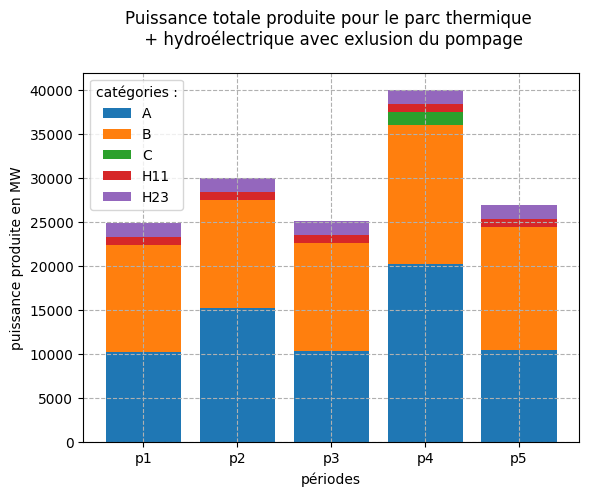

In [10]:
pdict54={k:[v.x for v in y54.select(k,'*')] for k in categories53}
df54=pd.DataFrame(pdict54)

plt.bar(periodes,df54['A'],label='A')
plt.bar(periodes,df54['B'],bottom=df54['A'],label='B')
plt.bar(periodes,df54['C'],bottom=df54['A']+df54['B'],label='C')
plt.bar(periodes,df54['H11'],bottom=df54['A']+df54['B']+df54['C'],label='H11')
plt.bar(periodes,df54['H23'],bottom=df54['A']+df54['B']+df54['C']+df54['H11'],label='H23')
plt.legend(title="catégories :")
plt.xlabel('périodes')
plt.ylabel('puissance produite en MW')
plt.title("Puissance totale produite pour le parc thermique \n + hydroélectrique avec exlusion du pompage",pad=20)
plt.grid(linestyle='dashed')

plt.show()

### 6. Désagrégation

In [2]:
A=[(f"A{i}",[2000,850,1,1000,2,2000,0]) for i in range(1,13)]
B=[(f"B{i}",[1750,1250,1,2600,1.3,1000,0]) for i in range(1,11)]
C=[(f"C{i}",[4000,1500,1,3000,3,500,0]) for i in range(1,6)]
H=[('H11',[900,900,1,90,0,1500,0.31]),('H12',[950,950,1,95,0,1500,0.33]), ('H13',[1000,1000,1,105,0,1500,0.35]), ('H14',[1100,1100,1,120,0,1500,0.38]),
('H21',[1400,1400,1,150,0,1200,0.47]), ('H22',[1500,1500,1,165,0,1200,0.5]), ('H23',[1600,1600,1,185,0,1200,0.53]), ('H24',[1700,1700,1,210,0,1200,0.56])]
categories6,Pmax6,Pmin6,nb6,cbase6,cmwh6,cstart6,Vab6=gp.multidict(A+B+C+H)

#### 6.1 individualisation des centrales

Nous allons maintenant individualiser le fonctionnement de chacune des centrales de chacune des catégories.

In [4]:
model61=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n61=model61.addVars(categories6,periodes,vtype=gp.GRB.BINARY)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y61=model61.addVars(categories6,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales démarrées à chaque période ppour chaque catégorie
x61=model61.addVars(categories6,periodes,lb=0,vtype=gp.GRB.CONTINUOUS)
#variable binaire qui indique le déclenchement d'au moins une centrale hydraulique
s61=model61.addVar(vtype=gp.GRB.BINARY)

Set parameter TokenServer to value "dev.cma.mines-paristech.fr"


In [5]:
model61.setObjective(gp.quicksum(duree[p] * cmwh6[k]*(y61[k,p]-Pmin6[k]*n61[k,p]) 
+ cbase6[k]*duree[p]*n61[k,p] + cstart6[k]*x61[k,p]  for k in categories6 for p in periodes), gp.GRB.MINIMIZE)

reserve61={p:sum(n61[k,p]*Pmax6[k]-y61[k,p] for k in categories6) for p in periodes}
M=100000

In [8]:
contrainte61=model61.addConstrs((y61.sum('*',p)>=demande[p] for p in periodes)) 
contrainte62=model61.addConstrs((Pmin6[k]*n61[k,p]<=y61[k,p] for k in categories6 for p in periodes))
contrainte63=model61.addConstrs((y61[k,p]<=Pmax6[k]*n61[k,p] for k in categories6 for p in periodes)) 
contrainte64=model61.addConstrs((x61[k,p]>=n61[k,p]-n61[k,periodes[prev(p,'cyclique')]] for k in categories6 for p in periodes))
contrainte65=model61.addConstrs((reserve61[p]>=0.15*demande[p] for p in periodes))
contrainte66=model61.addConstr(sum((y61.sum('*',p)-demande[p])*duree[p] for p in periodes)>=3000*sum(Vab6[k]*n61[k,p]*duree[p] for k in categories6[27:35] for p in periodes))
contrainte67=model61.addConstrs((n61['H11',p]+n61['H12',p]+n61['H13',p]+n61['H14',p]==1 for p in periodes))
contrainte68=model61.addConstrs((n61['H21',p]+n61['H22',p]+n61['H23',p]+n61['H24',p]==1 for p in periodes))
contrainte69=model61.addConstr(sum(n61[k,p] for k in categories6[27:35] for p in periodes) >= 1 - 10000 * (1 - s61))
contrainte610=model61.addConstr(sum(Vab6[k]*n61[k,p]*duree[p] for k in categories6[27:35] for p in periodes)<=M*(1-s61))


model61.update()
model61.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 548 rows, 526 columns and 2087 nonzeros
Model fingerprint: 0x7c1e7f8a
Variable types: 350 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+05]
  Objective range  [4e+00, 9e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Presolve removed 82 rows and 41 columns
Presolve time: 0.00s
Presolved: 466 rows, 485 columns, 1710 nonzeros
Variable types: 135 continuous, 350 integer (350 binary)
Found heuristic solution: objective 1056700.0000

Root relaxation: objective 9.868757e+05, 264 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 986875.714    0    8 1056700.00 986875.714  6.61%     -    0s
H    0     0                 

In [9]:
ndict61={k:[int(v.x) for v in n61.select(k,'*')] for k in categories6}
df61=pd.DataFrame(ndict61)
df61.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,C4,C5,H11,H12,H13,H14,H21,H22,H23,H24
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
3,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,1,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0


#### 6.2 planification au pas horaire

Cette question s'intéresse à la discrétisation, au pas horaire, de l'horizon de planification et du profil de demande.

In [4]:
P1=[(f"{i}h",[15000]) for i in range(0,6)]
P2=[(f"{i}h",[30000]) for i in range(6,9)]
P3=[(f"{i}h",[25000]) for i in range(9,15)]
P4=[(f"{i}h",[40000]) for i in range(15,18)]
P5=[(f"{i}h",[27000]) for i in range(18,24)]

heure62,demande62=gp.multidict(P1+P2+P3+P4+P5)

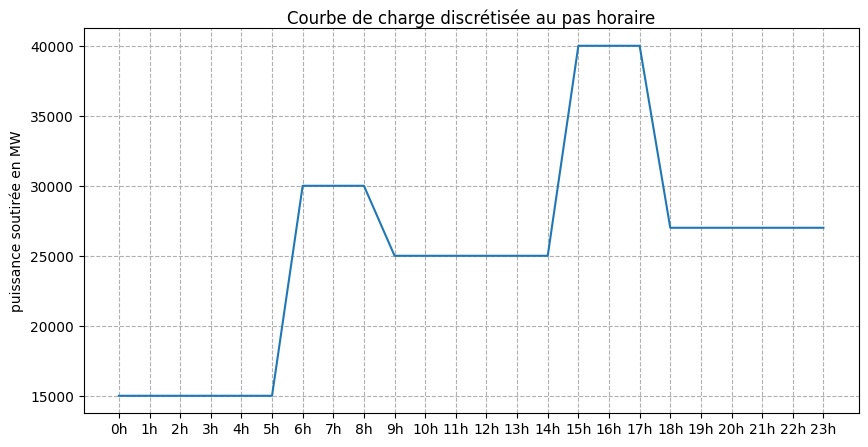

In [21]:
fig = plt.figure(figsize=(10, 5))
plt.plot(heure62,demande62.values())
plt.ylabel('puissance soutirée en MW')
plt.title("Courbe de charge discrétisée au pas horaire",pad=0)
plt.grid(linestyle='dashed')

plt.show()

In [5]:
model62=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n62=model62.addVars(categories6,heure62,vtype=gp.GRB.BINARY)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y62=model62.addVars(categories6,heure62,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales démarrées à chaque période ppour chaque catégorie
x62=model62.addVars(categories6,heure62,lb=0,vtype=gp.GRB.CONTINUOUS)
#variable binaire qui indique le déclenchement d'au moins une centrale hydraulique
s62=model62.addVar(vtype=gp.GRB.BINARY)

Set parameter TokenServer to value "dev.cma.mines-paristech.fr"


In [6]:
model62.setObjective(gp.quicksum(cmwh6[k]*(y62[k,h]-Pmin6[k]*n62[k,h]) 
+ cbase6[k]*n62[k,h] + cstart6[k]*x62[k,h]  for k in categories6 for h in heure62), gp.GRB.MINIMIZE)

reserve62={h:sum(n62[k,h]*Pmax6[k]-y62[k,h] for k in categories6) for h in heure62}
M=100000

In [7]:
contrainte621=model62.addConstrs((y62.sum('*',h)>=demande62[h] for h in heure62)) 
contrainte622=model62.addConstrs((Pmin6[k]*n62[k,h]<=y62[k,h] for k in categories6 for h in heure62))
contrainte623=model62.addConstrs((y62[k,h]<=Pmax6[k]*n62[k,h] for k in categories6 for h in heure62)) 
contrainte624=model62.addConstrs((x62[k,h]>=n62[k,h]-n62[k,heure62[prev2(h,'cyclique')]] for k in categories6 for h in heure62))
contrainte625=model62.addConstrs((reserve62[h]>=0.15*demande62[h] for h in heure62))
contrainte626=model62.addConstr(sum((y62.sum('*',h)-demande62[h]) for h in heure62)>=3000*sum(Vab6[k]*n62[k,h] for k in categories6[27:35] for h in heure62))
contrainte627=model62.addConstrs((n62['H11',h]+n62['H12',h]+n62['H13',h]+n62['H14',h]==1 for h in heure62))
contrainte628=model62.addConstrs((n62['H21',h]+n62['H22',h]+n62['H23',h]+n62['H24',h]==1 for h in heure62))
contrainte629=model62.addConstr(sum(n62[k,h] for k in categories6[27:35] for h in heure62) >= 1 - 10000 * (1 - s62))
contrainte6210=model62.addConstr(sum(Vab6[k]*n62[k,h] for k in categories6[27:35] for h in heure62)<=M*(1-s62))


model62.update()
model62.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2619 rows, 2521 columns and 10010 nonzeros
Model fingerprint: 0x50fdb8c4
Variable types: 1680 continuous, 841 integer (841 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+05]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Presolve removed 386 rows and 193 columns
Presolve time: 0.02s
Presolved: 2233 rows, 2328 columns, 8208 nonzeros
Variable types: 648 continuous, 1680 integer (1680 binary)
Found heuristic solution: objective 1044700.0000

Root relaxation: objective 9.868757e+05, 1420 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 986875.714    0   29 1044700.00 986875.714  5.54%     -    0s
H    0     0      

In [20]:
ndict621={k:[int(v.x) for v in n62.select(k,'*')] for k in categories6}
df621=pd.DataFrame(ndict621)
df621.head(7)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,C4,C5,H11,H12,H13,H14,H21,H22,H23,H24
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
1,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
2,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
3,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
4,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
5,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
6,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1


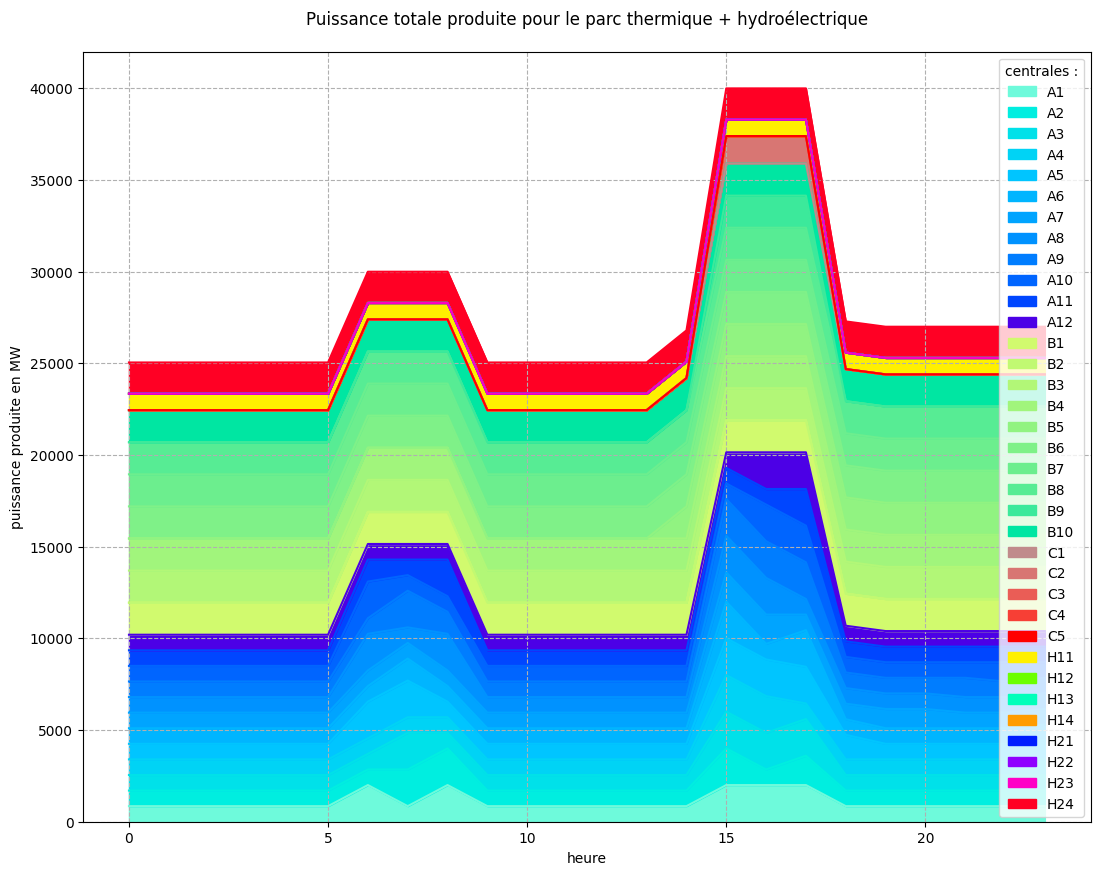

In [20]:
pdict62={k:[v.x for v in y62.select(k,'*')] for k in categories6}
df62=pd.DataFrame(pdict62)

colors=["#6efadb","#00eee0","#00e1e9","#00d3f5","#00c5ff","#00b5ff","#00a4ff","#0092ff","#007dff","#0065ff","#0046ff","#4c00e6","#d1fa6e","#c1f972","#b2f777","#a1f57c","#91f381","#7ff188",
"#6cee8e","#57ec94","#3ce99b","#00e6a2","#c08b8b","#d87673","#ea5d56","#f73f35","#ff0000","#fff000","#6CFF00","#00FFBA","#FF9C00","#001EFF","#9000FF","#FF00C6","#FF0024"]
df62.plot.area(figsize=(13,10),color=colors)
plt.xlabel('heure')
plt.ylabel('puissance produite en MW')
plt.title("Puissance totale produite pour le parc thermique + hydroélectrique",pad=20)
plt.grid(linestyle='dashed')
plt.legend(title="centrales :")

plt.show()

On observe que les centrales hydroélectriques sont utilisées aux paliers 1 (H11) et 4 (H24) respectivement. On remarque que la centrale C2 est appelée pour couvrir le pic de consommation entre 15h et 17h

#### 6.3 Précision du profil de demande

Nous allons maintenant préciser le profil de demande pour chaque heure.

In [3]:
heure63,demande63=gp.multidict({'0h': 17000, '1h': 15000, '2h': 14000, '3h': 13000, '4h': 13000, '5h': 18000, 
'6h': 29000, '7h': 32000, '8h': 29000, '9h': 27000, '10h': 25000, '11h': 25000, '12h': 24000, '13h': 24000, '14h': 25000, 
'15h': 38000, '16h': 42000, '17h': 40000, '18h': 33000, '19h': 31000, '20h': 27000, '21h': 26000, '22h': 24000, '23h': 21000})

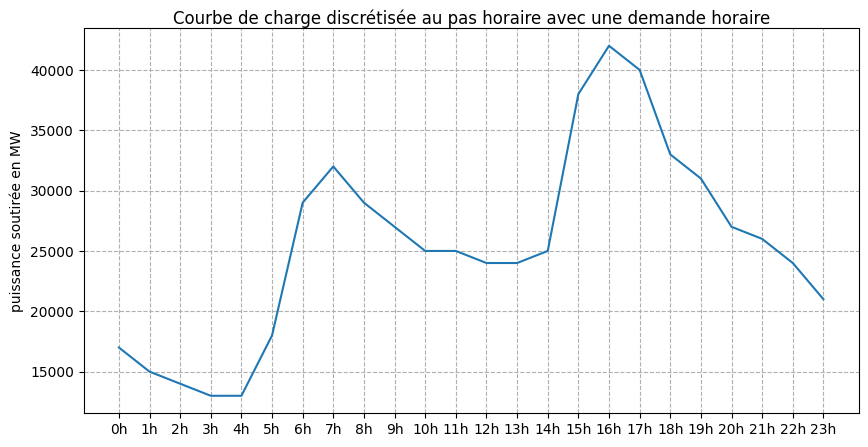

In [19]:
fig = plt.figure(figsize=(10, 5))
plt.plot(heure63,demande63.values())
plt.ylabel('puissance soutirée en MW')
plt.title("Courbe de charge discrétisée au pas horaire avec une demande horaire",pad=0)
plt.grid(linestyle='dashed')

plt.show()

In [15]:
model63=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n63=model63.addVars(categories6,heure63,vtype=gp.GRB.BINARY)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y63=model63.addVars(categories6,heure63,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales démarrées à chaque période ppour chaque catégorie
x63=model63.addVars(categories6,heure63,lb=0,vtype=gp.GRB.CONTINUOUS)
#variable binaire qui indique le déclenchement d'au moins une centrale hydraulique
s63=model63.addVar(vtype=gp.GRB.BINARY)

In [16]:
model63.setObjective(gp.quicksum(cmwh6[k]*(y63[k,h]-Pmin6[k]*n63[k,h]) 
+ cbase6[k]*n63[k,h] + cstart6[k]*x63[k,h]  for k in categories6 for h in heure63), gp.GRB.MINIMIZE)

reserve63={h:sum(n63[k,h]*Pmax6[k]-y63[k,h] for k in categories6) for h in heure63}
M=100000

In [17]:
contrainte631=model63.addConstrs((y63.sum('*',h)>=demande63[h] for h in heure63)) 
contrainte632=model63.addConstrs((Pmin6[k]*n63[k,h]<=y63[k,h] for k in categories6 for h in heure63))
contrainte633=model63.addConstrs((y63[k,h]<=Pmax6[k]*n63[k,h] for k in categories6 for h in heure63)) 
contrainte634=model63.addConstrs((x63[k,h]>=n63[k,h]-n63[k,heure63[prev2(h,'cyclique')]] for k in categories6 for h in heure63))
contrainte635=model63.addConstrs((reserve63[h]>=0.15*demande63[h] for h in heure63))
contrainte636=model63.addConstr(sum((y63.sum('*',h)-demande63[h]) for h in heure63)>=3000*sum(Vab6[k]*n63[k,h] for k in categories6[27:35] for h in heure63))
contrainte637=model63.addConstrs((n63['H11',h]+n63['H12',h]+n63['H13',h]+n63['H14',h]==1 for h in heure63))
contrainte638=model63.addConstrs((n63['H21',h]+n63['H22',h]+n63['H23',h]+n63['H24',h]==1 for h in heure63))
contrainte639=model63.addConstr(sum(n63[k,h] for k in categories6[27:35] for h in heure63) >= 1 - 10000 * (1 - s63))
contrainte6310=model63.addConstr(sum(Vab6[k]*n63[k,h] for k in categories6[27:35] for h in heure63)<=M*(1-s63))


model63.update()
model63.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2619 rows, 2521 columns and 10010 nonzeros
Model fingerprint: 0x6b6265c6
Variable types: 1680 continuous, 841 integer (841 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+05]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Presolve removed 386 rows and 193 columns
Presolve time: 0.02s
Presolved: 2233 rows, 2328 columns, 8208 nonzeros
Variable types: 648 continuous, 1680 integer (1680 binary)
Found heuristic solution: objective 1048960.0000

Root relaxation: objective 9.881613e+05, 1423 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 988161.327    0   24 1048960.00 988161.327  5.80%     -    0s
H    0     0      

In [25]:
ndict631={k:[int(v.x) for v in n63.select(k,'*')] for k in categories6}
df631=pd.DataFrame(ndict631)
df631.head(7)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,C4,C5,H11,H12,H13,H14,H21,H22,H23,H24
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
5,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
6,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0


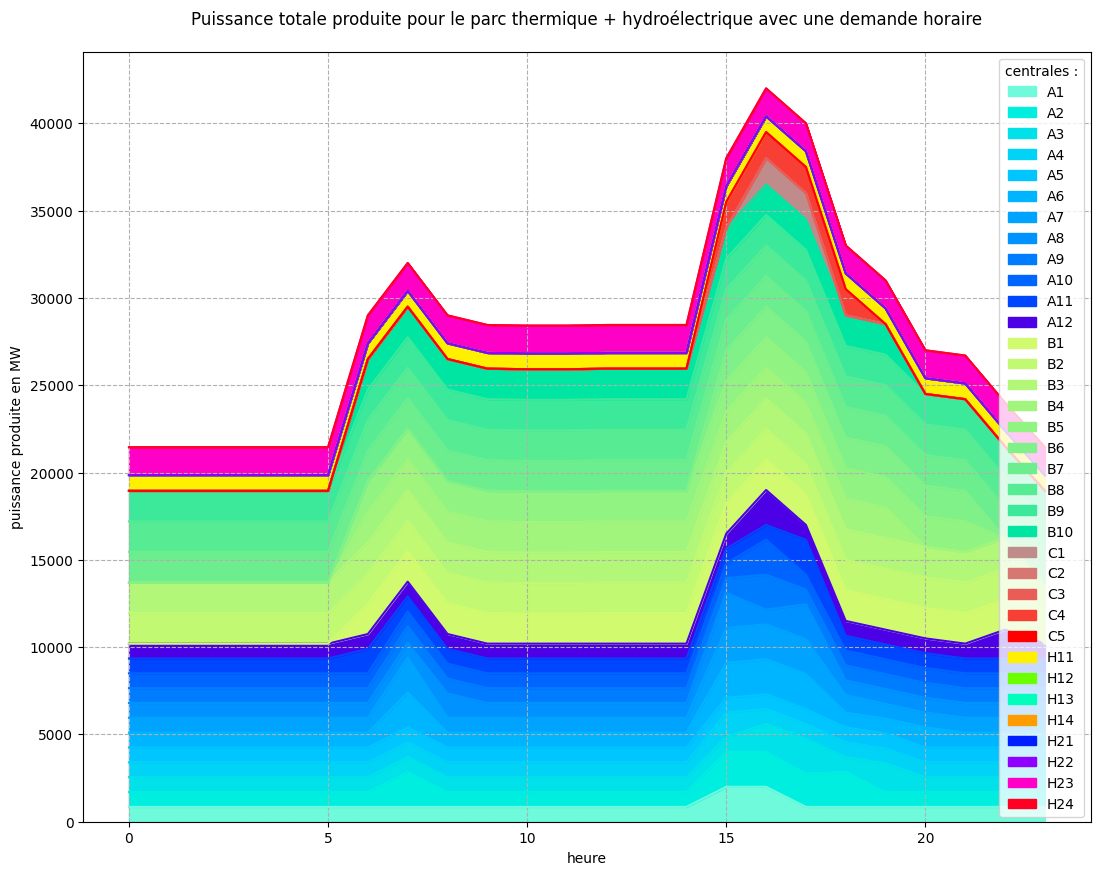

In [19]:
pdict63={k:[v.x for v in y63.select(k,'*')] for k in categories6}
df63=pd.DataFrame(pdict63)

colors=["#6efadb","#00eee0","#00e1e9","#00d3f5","#00c5ff","#00b5ff","#00a4ff","#0092ff","#007dff","#0065ff","#0046ff","#4c00e6","#d1fa6e","#c1f972","#b2f777","#a1f57c","#91f381","#7ff188",
"#6cee8e","#57ec94","#3ce99b","#00e6a2","#c08b8b","#d87673","#ea5d56","#f73f35","#ff0000","#fff000","#6CFF00","#00FFBA","#FF9C00","#001EFF","#9000FF","#FF00C6","#FF0024"]
df63.plot.area(figsize=(13,10),color=colors)
plt.xlabel('heure')
plt.ylabel('puissance produite en MW')
plt.title("Puissance totale produite pour le parc thermique + hydroélectrique avec une demande horaire",pad=20)
plt.grid(linestyle='dashed')
plt.legend(title="centrales :")

La 1ère centrale hydroélectrique fonctionne toujours au palier 1 tandis que la 2ème fonctionne maintenant au palier 3.

#### 6.4 Discrétisation à un pas de 2 heures

Nous allons maintenant discrétiser l'horizon temporel avec un pas de 2h

In [4]:
heure64,demande64=gp.multidict({'1': 16000, '2': 14000, '3': 16000, '4': 30000, '5': 28000, 
'6': 25000, '7': 24000, '8': 33000, '9': 41000, '10': 32000, '11': 26000, '12': 22000})

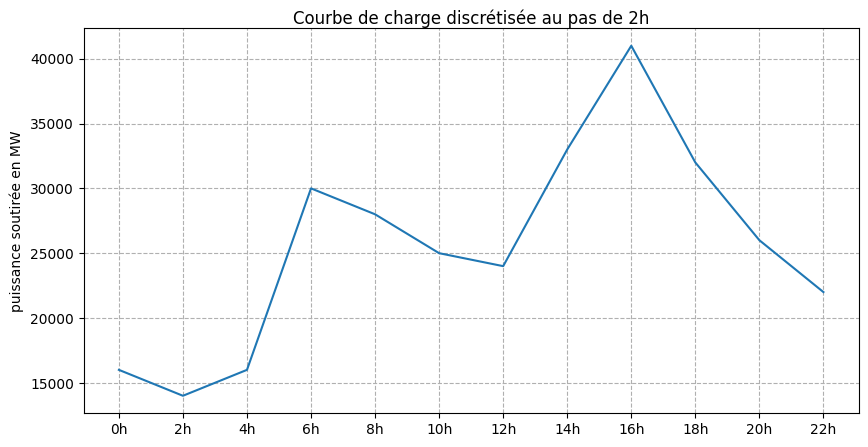

In [4]:
fig = plt.figure(figsize=(10, 5))
plt.plot(['0h','2h','4h','6h','8h','10h','12h','14h','16h','18h','20h','22h'],demande64.values())
plt.ylabel('puissance soutirée en MW')
plt.title("Courbe de charge discrétisée au pas de 2h",pad=0)
plt.grid(linestyle='dashed')

plt.show()

In [5]:
model64=gp.Model()
#nombre de centrales allumées à chaque période pour chaque catégorie
n64=model64.addVars(categories6,heure64,vtype=gp.GRB.BINARY)
#puissance produite par l'ensemble des centrales à chaque période pour chaque catégorie
y64=model64.addVars(categories6,heure64,lb=0,vtype=gp.GRB.CONTINUOUS)
#nombre de centrales démarrées à chaque période ppour chaque catégorie
x64=model64.addVars(categories6,heure64,lb=0,vtype=gp.GRB.CONTINUOUS)
#variable binaire qui indique le déclenchement d'au moins une centrale hydraulique
s64=model64.addVar(vtype=gp.GRB.BINARY)

Set parameter TokenServer to value "dev.cma.mines-paristech.fr"


In [6]:
model64.setObjective(gp.quicksum(cmwh6[k]*(y64[k,h]-Pmin6[k]*n64[k,h]) 
+ cbase6[k]*n64[k,h] + cstart6[k]*x64[k,h]  for k in categories6 for h in heure64), gp.GRB.MINIMIZE)

reserve64={h:sum(n64[k,h]*Pmax6[k]-y64[k,h] for k in categories6) for h in heure64}
M=100000

In [7]:
contrainte641=model64.addConstrs((y64.sum('*',h)>=demande64[h] for h in heure64)) 
contrainte642=model64.addConstrs((Pmin6[k]*n64[k,h]<=y64[k,h] for k in categories6 for h in heure64))
contrainte643=model64.addConstrs((y64[k,h]<=Pmax6[k]*n64[k,h] for k in categories6 for h in heure64)) 
contrainte644=model64.addConstrs((x64[k,h]>=n64[k,h]-n64[k,heure64[prev3(h,'cyclique')]] for k in categories6 for h in heure64))
contrainte645=model64.addConstrs((reserve64[h]>=0.15*demande64[h] for h in heure64))
contrainte646=model64.addConstr(sum((y64.sum('*',h)-demande64[h]) for h in heure64)>=3000*sum(Vab6[k]*n64[k,h] for k in categories6[27:35] for h in heure64))
contrainte647=model64.addConstrs((n64['H11',h]+n64['H12',h]+n64['H13',h]+n64['H14',h]==1 for h in heure64))
contrainte648=model64.addConstrs((n64['H21',h]+n64['H22',h]+n64['H23',h]+n64['H24',h]==1 for h in heure64))
contrainte649=model64.addConstr(sum(n64[k,h] for k in categories6[27:35] for h in heure64) >= 1 - 10000 * (1 - s64))
contrainte6410=model64.addConstr(sum(Vab6[k]*n64[k,h] for k in categories6[27:35] for h in heure64)<=M*(1-s64))

model64.update()
model64.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1311 rows, 1261 columns and 5006 nonzeros
Model fingerprint: 0x55c24487
Variable types: 840 continuous, 421 integer (421 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+05]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]
Presolve removed 194 rows and 97 columns
Presolve time: 0.02s
Presolved: 1117 rows, 1164 columns, 4128 nonzeros
Variable types: 324 continuous, 840 integer (840 binary)
Found heuristic solution: objective 533580.00000

Root relaxation: objective 4.973818e+05, 727 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 497381.791    0   30 533580.000 497381.791  6.78%     -    0s
H    0     0            

In [13]:
ndict641={k:[int(v.x) for v in n64.select(k,'*')] for k in categories6}
df641=pd.DataFrame(ndict641)
df641.head(12)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,C4,C5,H11,H12,H13,H14,H21,H22,H23,H24
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
5,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
6,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
7,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,1,0
8,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,1,0
9,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0


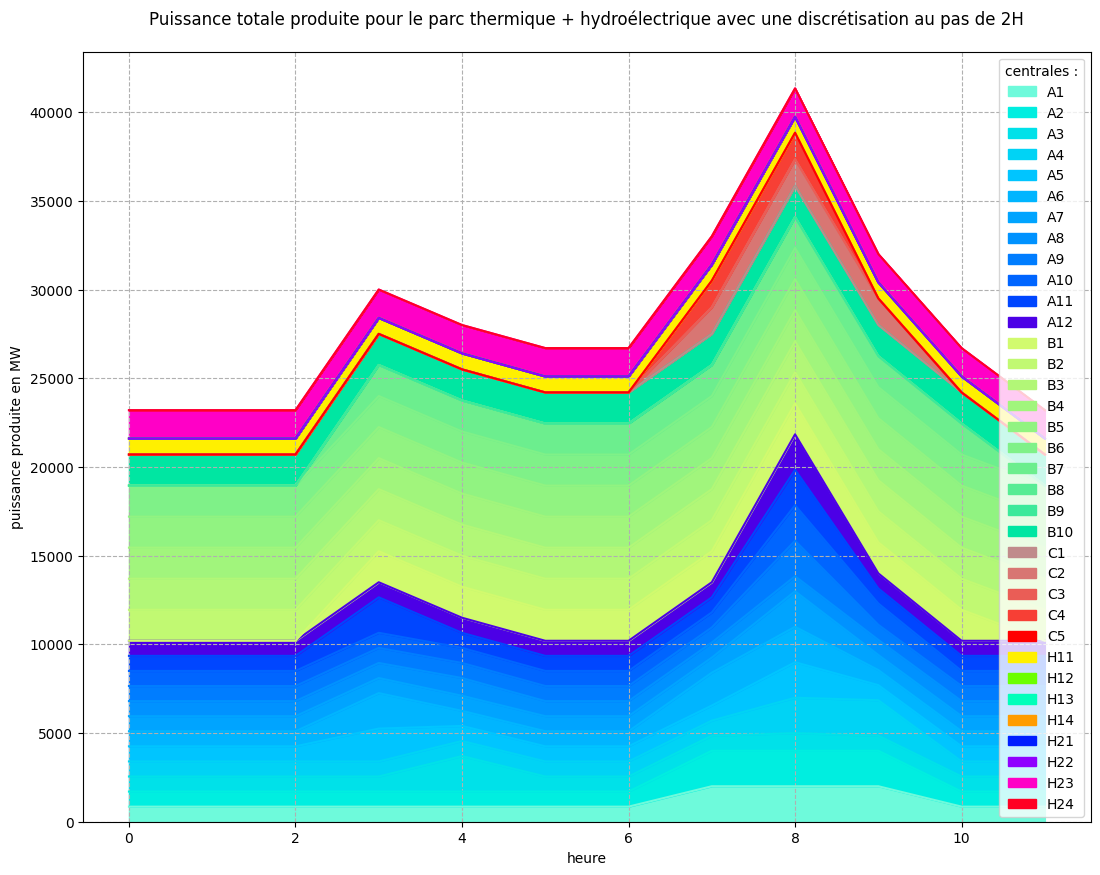

In [8]:
pdict64={k:[v.x for v in y64.select(k,'*')] for k in categories6}
df64=pd.DataFrame(pdict64)

colors=["#6efadb","#00eee0","#00e1e9","#00d3f5","#00c5ff","#00b5ff","#00a4ff","#0092ff","#007dff","#0065ff","#0046ff","#4c00e6","#d1fa6e","#c1f972","#b2f777","#a1f57c","#91f381","#7ff188",
"#6cee8e","#57ec94","#3ce99b","#00e6a2","#c08b8b","#d87673","#ea5d56","#f73f35","#ff0000","#fff000","#6CFF00","#00FFBA","#FF9C00","#001EFF","#9000FF","#FF00C6","#FF0024"]
df64.plot.area(figsize=(13,10),color=colors)
plt.xlabel('heure')
plt.ylabel('puissance produite en MW')
plt.title("Puissance totale produite pour le parc thermique + hydroélectrique avec une discrétisation au pas de 2H",pad=20)
plt.grid(linestyle='dashed')
plt.legend(title="centrales :")

### Conclusion

De l'écriture sur papier du modèle mathématique du problème d'optimisation jusqu'à l'analyse de sensibilité en passant par l'implémentation et la résolution numérique, ce projet nous a permis d'effectuer la démarche complète de résolution d'un problème d'optimisation linéaire. Nous avons alors pu améliorer notre compréhension pratique du solveur et apliquer les notions vues en cours. 